In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector


In [3]:
db = mysql.connector.connect(host = "localhost" , username = "root" , password = "mysql@987" , database = "ecommerce" )

cur = db.cursor()

##### 1. List all unique cities where customers are located.

In [4]:
query = """select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()


##### 2.count the number of orders placed in 2017

In [5]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

##### 3.Find the total sales per category.

In [6]:
query = """select products.product_category as category , round(sum(payments.payment_value) , 2) as sales  from products 
join order_items oi on oi.product_id = products.product_id
join payments on payments.order_id = oi.order_id 
 group by category  limit 50 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['category' , 'sales'])
df_cleaned = df.dropna()

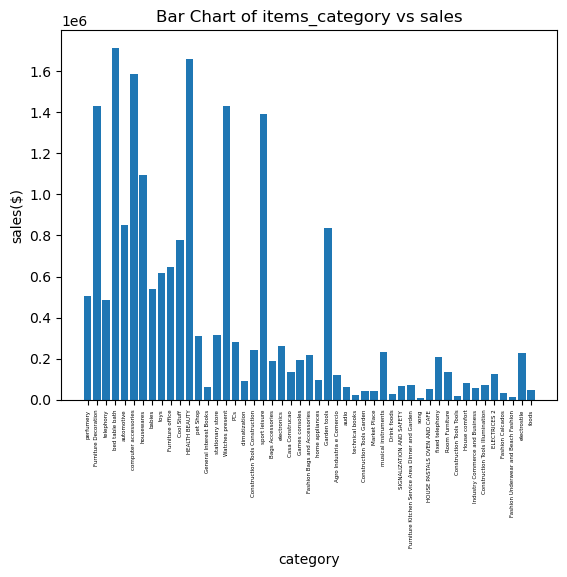

In [7]:
plt.bar(df_cleaned['category'] , df_cleaned['sales'])
# Customize the plot (optional)
plt.xlabel('category')  # Set x-axis label
plt.ylabel('sales($)')  # Set y-axis label
plt.title('Bar Chart of items_category vs sales')  # Set plot title
plt.xticks(rotation= 'vertical' , fontsize=4 ) 
plt.show()

 #### 4.Calculate the percentage of orders that were paid in installments.

In [8]:
query = """ select (sum(case when payment_installments >= 1 then 1
 else  0 end)*100)/count(payment_installments) as  percentage_orders_on_emi
 from payments  """
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9981')

####  5.Count the number of customers from each state. 

In [9]:
query = """ select customer_state , count(customer_id) from customers 
group by customer_state  """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['states' , 'customer_count'])
df.head()

,states,customer_count
0,SP,41746
1,SC,3637
2,MG,11635
3,PR,5045
4,RJ,12852


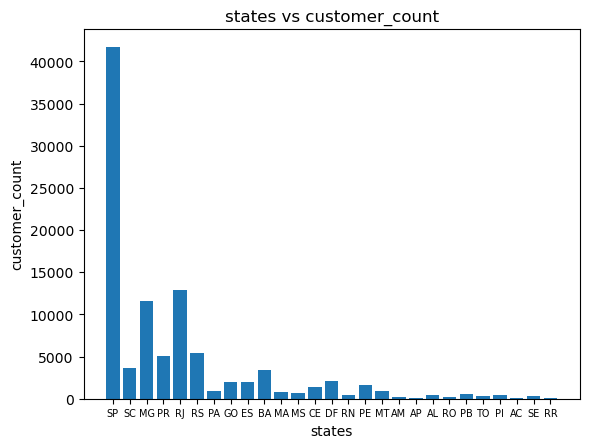

<Figure size 400x600 with 0 Axes>

In [10]:
plt.bar(df['states'] , df['customer_count'])
plt.xlabel('states')  # Set x-axis label
plt.ylabel('customer_count')  # Set y-axis label
plt.title('states vs customer_count')  # Set plot title
plt.xticks( fontsize= 7 ) 
plt.figure(figsize = (4,6))
plt.show()

## Advance queries

##### 1. Calculate the number of orders per month in 2018. 

In [11]:
query = '''select monthname(order_purchase_timestamp) as order_month , count(order_id) as order_count from orders
where year(order_purchase_timestamp) = 2018 
group by  order_month'''
cur.execute(query)
data = cur.fetchall()
df2 = pd.DataFrame(data , columns = ['order_month' , 'order_count'])
df2.head(21)

,order_month,order_count
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


### 2.Find the average number of products per order, grouped by customer city.

In [12]:
query = '''with count_per_order as 
(select o.order_id , o.customer_id , count(oi.order_id) as order_count from orders as o
join order_items oi
on o.order_id = oi.order_id
group by o.order_id , o.customer_id )

select c.customer_city , round(avg(cpo.order_count) , 2) avg_order from customers as c
join count_per_order as cpo
on c.customer_id = cpo.customer_id
group by  c.customer_city order by avg_order desc
'''
cur.execute(query)
data = cur.fetchall()
df2 = pd.DataFrame(data , columns = ['customer_city' , 'avg_order_count'])
df2.head()

,customer_city,avg_order_count
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


#### 3.Calculate the percentage of total revenue contributed by each product category.

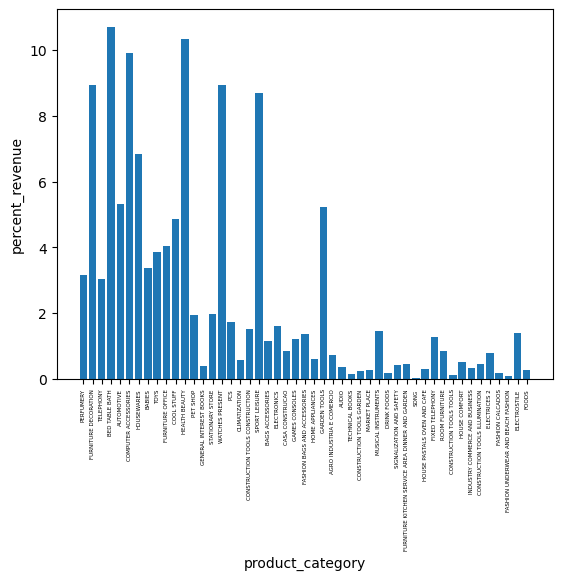

In [13]:
query = """select upper(products.product_category) as category , round(((sum(payments.payment_value)* 100)/(select sum(payment_value) from payments)) ,2) as percent from products
join order_items oi on  products.product_id = oi.product_id
join payments on payments.order_id = oi.order_id
group by products.product_category limit 50 """
cur.execute(query) 
data = cur.fetchall()
df3 = pd.DataFrame(data , columns  = ["product_category" , "percent_revenue"])
dc = df3.dropna()

plt.bar(dc['product_category'] , dc['percent_revenue'])
plt.xlabel('product_category')
plt.ylabel('percent_revenue')
plt.xticks(rotation = 'vertical' , fontsize = 4)
plt.show()

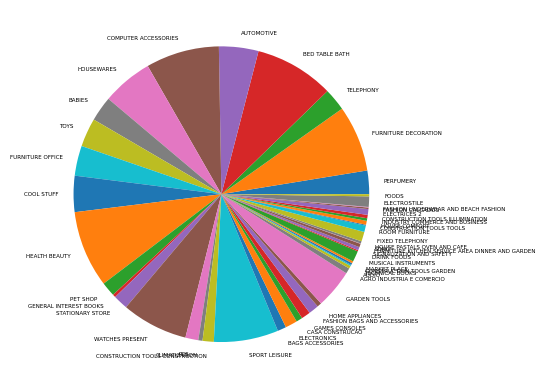

In [14]:
plt.pie (dc['percent_revenue'] , labels = dc['product_category'] , textprops={'fontsize': 4 })
plt.show()

 #### 4.Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query = """select upper(products.product_category) as category ,count(oi.product_id) order_qty , round(avg(oi.price) ,2) price
from products
join order_items oi on  products.product_id = oi.product_id
group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['category' , 'order_qty' , 'avg_price'])
dc = df.dropna()
dc.head(1000)


,category,order_qty,avg_price
0,HEALTH BEAUTY,9670,130.16
1,SPORT LEISURE,8641,114.34
2,COOL STUFF,3796,167.36
3,COMPUTER ACCESSORIES,7827,116.51
4,WATCHES PRESENT,5991,201.14
...,...,...,...
69,FLOWERS,33,33.64
70,KITCHEN PORTABLE AND FOOD COACH,15,264.57
71,HOUSE COMFORT 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


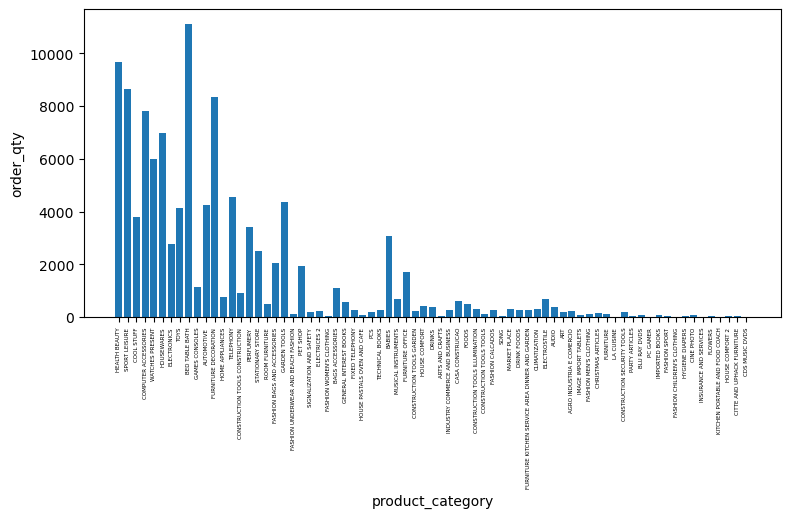

In [16]:
plt.figure(figsize=(9, 4))
plt.bar(dc['category'] , dc['order_qty'])
plt.xlabel('product_category')
plt.ylabel('order_qty')
plt.xticks(rotation = 'vertical' , fontsize = 4)
plt.show()


C:\Users\91882\AppData\Local\Temp\ipykernel_13212\2943912749.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dc['category'] , rotation = 'vertical' , fontsize = 4)


<Figure size 800x400 with 0 Axes>

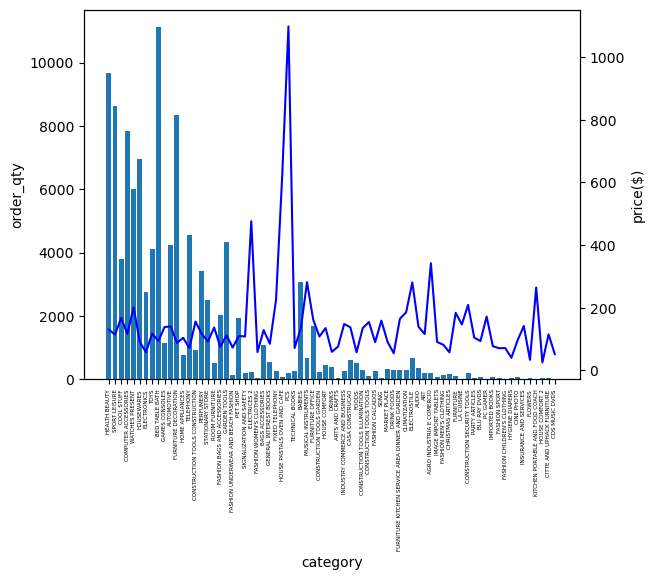

In [17]:
#here we used mean because we have used group
plt.figure(figsize=(8, 4))
fig , ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(dc['category'] , dc['order_qty'])
ax2.plot(dc['category'] , dc['avg_price'], 'b-')

ax1.set_xlabel('category')
ax1.set_ylabel('order_qty')
ax2.set_ylabel('price($)')
ax1.set_xticklabels(dc['category'] , rotation = 'vertical' , fontsize = 4)

plt.show()

In [18]:
import numpy as np 
arr1 = dc['order_qty']
arr2 = dc['avg_price']
a = np.corrcoef([arr1 , arr2]) # correlation factor gives the relation of proprtonality or inverse
print("the correlation coef is " , a[0][-1])

the correlation coef is  -0.10625383251211559


 #### 5.Calculate the total revenue generated by each seller, and rank them by revenue.

In [19]:
query = '''select * , dense_rank() over(order by revenue desc) as ranking from
(select sellers.seller_id as seller , round(sum(payment_value) , 2) as revenue from sellers
join order_items oi on oi.seller_id = sellers.seller_id
join payments on payments.order_id = oi.order_id
group by seller ) as a '''

cur.execute(query) 
data = cur.fetchall()


### Advanced Queries

##### 1.Calculate the moving average of order values for each customer over their order history.

##### 2.Calculate the cumulative sales per month for each year.

In [20]:
query = '''select sale_year , sale_month , round(sum(sales) over(partition by sale_year order by sale_year, sale_month ) , 2)
as cumm_sales
from
(select year(orders.order_purchase_timestamp) sale_year, 
month(orders.order_purchase_timestamp) as sale_month , 
round(sum(payments.payment_value ) , 2) sales
from  orders join payments on payments.order_id = orders.order_id
group by sale_year , sale_month order by  sale_year , sale_month) as b '''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['year' , 'month' , 'cumm_sales'] )
pivoted_data = df.pivot_table(values='cumm_sales', index='month', columns='year')
pivoted_data.head()

year,2016,2017,2018
month,,,
1,NaN,138488.04,1115004.18
2,NaN,430396.05,2107467.52
3,NaN,880259.65,3267119.64
4,NaN,1298047.68,4427905.12
5,NaN,1890966.50,5581887.27


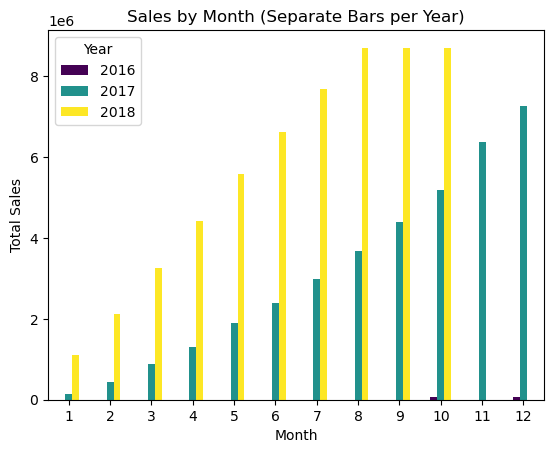

In [21]:
# Create the bar plot (using stacked=False to avoid stacking)
pivoted_data.plot(kind='bar', stacked=False, colormap='viridis')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Sales by Month (Separate Bars per Year)')
plt.legend(title='Year')  # Add legend with year labels
plt.xticks(rotation=0)  # Rotate x-axis labels to prevent overlapping

plt.show()

 ##### 3.Calculate the year-over-year growth rate of total sales.

In [22]:
query = ''' with a as
(select year(orders.order_purchase_timestamp) sale_year,  
round(sum(payments.payment_value ) , 2) sales
from  orders join payments on payments.order_id = orders.order_id
group by sale_year order by  sale_year  )
select sale_year , sales , 
((sales - (lag(sales , 1) over(order by sale_year))) * 100/lag(sales , 1) over(order by sale_year)) growth_rate from a
'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['year' , 'year_sale' , 'growth_rate(%)'] )
df


,year,year_sale,growth_rate(%)
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


##### 4.Identify the top 3 customers who spent the most money in each year.

In [24]:
query = """select * from
 (select customers.customer_id , year(orders.order_purchase_timestamp) year_spent ,
 round(sum(payments.payment_value) , 2) total_spent, dense_rank() over (partition by year(orders.order_purchase_timestamp)order by sum(payments.payment_value) desc) rnk
 from customers
 join orders  on orders.customer_id = customers.customer_id 
 join payments on payments.order_id = orders.order_id
 group by year_spent , customers.customer_id order by year_spent asc, rnk asc) as b  
 where b.rnk < 4 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['customer_id', 'year' , 'total_spent' , 'rank'] )
df

,customer_id,year,total_spent,rank
0,a9dc96b027d1252bbac0a9b72d837fc6,2016,1423.55,1
1,1d34ed25963d5aae4cf3d7f3a4cda173,2016,1400.74,2
2,4a06381959b6670756de02e07b83815f,2016,1227.78,3
3,1617b1357756262bfa56ab541c47bc16,2017,13664.08,1
4,c6e2731c5b391845f6800c97401a43a9,2017,6929.31,2
5,3fd6777bbce08a352fddd04e4a7cc8f6,2017,6726.66,3
6,ec5b2ba62e574342386871631fafd3fc,2018,7274.88,1
7,f48d464a0baaea338cb25f816991ab1f,2018,6922.21,2
8,e0a2412720e9ea4f26c1ac985f6a7358,2018,4809.44,3


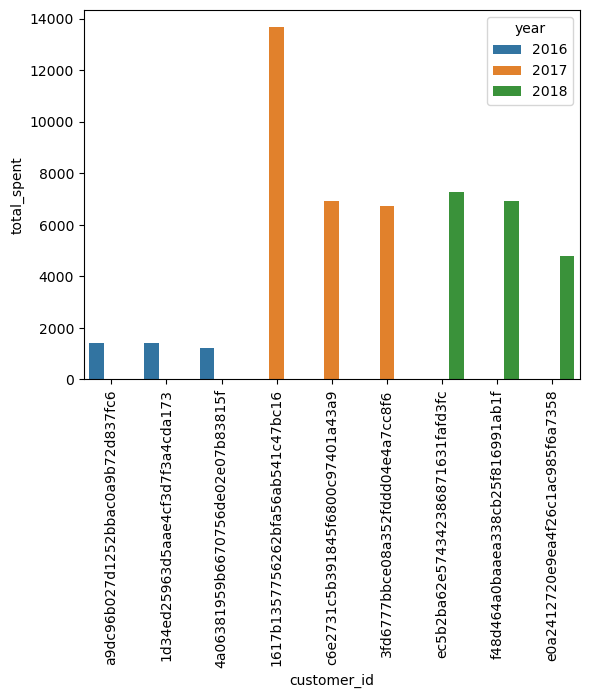

In [27]:
sns.barplot(x = 'customer_id' , y = 'total_spent' ,data = df , hue = 'year' )
plt.xticks(rotation = 90)
plt.show()

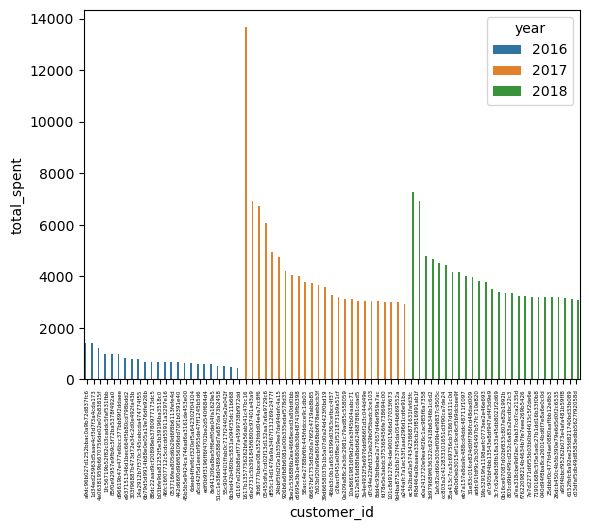

In [34]:
query = """select * from
 (select customers.customer_id , year(orders.order_purchase_timestamp) year_spent ,
 round(sum(payments.payment_value) , 2) total_spent, dense_rank() over (partition by year(orders.order_purchase_timestamp)order by sum(payments.payment_value) desc) rnk
 from customers
 join orders  on orders.customer_id = customers.customer_id 
 join payments on payments.order_id = orders.order_id
 group by year_spent , customers.customer_id order by year_spent asc, rnk asc) as b  
 where b.rnk < 25 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['customer_id', 'year' , 'total_spent' , 'rank'] )
df
sns.barplot(x = 'customer_id' , y = 'total_spent' ,data = df , hue = 'year' )
plt.xticks(rotation = 90, fontsize = 4)
plt.show()